In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import urllib.request
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [4]:
#list_metricas = ['average_clustering', 'coefficient_distribution_degree', 'density', 'average_degree', 'average_short_path']#, 'number_of_nodes']
list_metricas = ['average_clustering', 'coefficient_distribution_degree', 'density', 'average_degree']

list_variables_a = [
    #'Patrimonio_Liquido',
    #'Cotas_Emitidas',
    #'Valor_Patrimonial_Cotas',
    'Percentual_Rentabilidade_Efetiva_Mes',
    'Percentual_Rentabilidade_Patrimonial_Mes',
    #'Percentual_Dividend_Yield_Mes',
    #'Percentual_Amortizacao_Cotas_Mes',
]


list_variables_b = [
    'Valor_Ativo',
    'Percentual_Despesas_Taxa_Administracao',
    'Percentual_Despesas_Agente_Custodiante',
    'Total_Necessidades_Liquidez',
    'Disponibilidades',
    'Titulos_Publicos',
    'Titulos_Privados',
    'Fundos_Renda_Fixa',
    'Total_Investido',
    'Direitos_Bens_Imoveis',
    'Terrenos',
    'Imoveis_Renda_Acabados',
    'Imoveis_Renda_Construcao',
    'Imoveis_Venda_Acabados',
    'Imoveis_Venda_Construcao',
    'Outros_Direitos_Reais',
    'Acoes',
    #'Debentures',
    #'Bonus_Subscricao',
    'Certificados_Deposito_Valores_Mobiliarios',
    #'Cedulas_Debentures',
    #'Fundo_Acoes',
    #'FIP',
    'FII',
    #'FDIC',
    'Outras_Cotas_FI',
    #'Notas_Promissorias',
    'Acoes_Sociedades_Atividades_FII',
    'Cotas_Sociedades_Atividades_FII',
    'CEPAC',
    'CRI',
    #'Letras_Hipotecarias',
    #'LCI',
    #'LIG',
    'Outros_Valores_Mobliarios',
    'Valores_Receber',
    'Contas_Receber_Aluguel',
    'Contas_Receber_Venda_Imoveis',
    'Outros_Valores_Receber',
    'Rendimentos_Distribuir',
    'Taxa_Administracao_Pagar',
    'Taxa_Performance_Pagar',
    'Obrigacoes_Aquisicao_Imoveis',
    #'Adiantamento_Venda_Imoveis',
    'Adiantamento_Alugueis',
    'Obrigacoes_Securitizacao_Recebiveis',
    #'Instrumentos_Financeiros_Derivativos',
    'Provisoes_Contigencias',
    'Outros_Valores_Pagar',
    'Total_Passivo',
 ]

list_variables = list_variables_a + list_variables_b

list_cat = [
    #'Mandato',
    #'Segmento_Atuacao',
    #'Publico_Alvo',
    #'Tipo_Gestao',
]

ds_fii = xr.open_dataset('dataset/cvm/dataset_cvm_metrica_mensal.nc').fillna(0)
df_dados_fii = pd.read_csv('dataset/cvm/dataset_cvm_metrica_mensal_dados.csv', index_col='CNPJ_Fundo')

df_fii = ds_fii.to_array().stack(var=['variable', 'metrica']).to_pandas()

df_fii[['TIR']] = df_dados_fii[['TIR']][df_dados_fii[['TIR']].fillna(0).apply(zscore).abs() <= 1].fillna(0)
df_fii[[ (v, 'coefficient_distribution_degree') for v in list_variables ]] = df_fii[[ (v, 'coefficient_distribution_degree') for v in list_variables ]][df_fii[[ (v, 'coefficient_distribution_degree') for v in list_variables ]].apply(zscore).abs() <= 1].fillna(0)
df_fii_cat =  df_dados_fii[list_cat]


cnpj_meses = xr.open_dataset('dataset/cvm/dataset_cvm_metrica_mensal.nc').fillna(0).Acoes.sel(metrica='number_of_nodes').to_pandas()

In [7]:
def dataset_filter(df, lista_variaveis, lista_metricas, lista_cnpj):
    cols = [ (v, m) for v in lista_variaveis for m in lista_metricas ] + [ ('TIR', '') ]
    df_out = df[df.index.isin(lista_cnpj)][ cols ]
    
    return df_out.drop(columns=[ ('TIR', '') ]), df_out[ [ ('TIR', '') ] ]

In [8]:
def select_cols(df_fii, numbers, corr_val = 0.5, list_cat = []):
    grupos_fiis = df_dados_fii[list_cat].dropna().agg('-'.join, axis=1)

    set_cols = set()

    for grupo in np.unique(grupos_fiis.values):
        cnpj_grupo = grupos_fiis[grupos_fiis==grupo].index.values


        df_dados = df_fii[df_fii.index.isin(cnpj_grupo)]
        corr = df_dados.corr()
        cols = corr['TIR'][corr['TIR'].abs() >= corr_val].abs().sort_values(ascending=False).index.values[1:(numbers+1)]

        for t in cols:
            set_cols.add(t)

    set_cols.discard(('TIR', ''))
    return list(set_cols)

In [9]:
import copy

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Resultado 1

Gráfico por classificação

In [15]:
def model(X, y):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.neural_network import MLPRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2/3)
    
    best_score_train = np.inf
    best_score_test = np.inf
    best_weights = None
    
    for i in range(1, 6):
        model_train = MLPRegressor(max_iter=5000)
        model_train.fit(X_train, y_train)

        y_pred = model_train.predict(X_train)
        score_train = mean_absolute_error(y_train, y_pred)
        error_train = list(y_train-y_pred)

        y_pred = model_train.predict(X_test)
        score_test = mean_absolute_error(y_test, y_pred)
        error_test = list(y_test-y_pred)

        if score_test < best_score_test:
            best_score_test = score_test
            best_score_train = score_train
            best_error_test = error_test
            best_error_train = error_train
            best_weights = model_train.get_params()
    
    print(f'Score = (train: {best_score_train:.3f}, test: {best_score_test:.3f})')
    return best_score_train, best_score_test, best_weights, best_error_train, best_error_test

In [16]:
tamanho_series = 48

num_test = 5


list_cnpj = cnpj_meses[cnpj_meses >= tamanho_series].index.values
df_fii_feature, df_fii_target = dataset_filter(df_fii, list_variables, list_metricas, list_cnpj)
df_fii_corr = pd.merge(df_fii_feature, df_fii_target, left_index=True, right_index=True)


preprocessing = OneHotEncoder().fit_transform(df_fii_cat[df_fii_cat.index.isin(df_fii_feature.index.values)]).toarray()

#cols_corr = select_cols(df_fii_corr, 50, 0.0, [])

x = []
y_train_1 = []
y_test_1 = []
weights_1 = []
error_train_1 = []
error_test_1 = []
y_train_2 = []
y_test_2 = []
weights_2 = []
error_train_2 = []
error_test_2 = []

for i in range(1):
    cols_corr = select_cols(df_fii_corr, 500, 0.0, [])
    x.append(len(cols_corr))

    print(f'---{i+1}: {len(cols_corr)}---')

    target = df_fii_target.values.flatten()
    features = df_fii_feature[cols_corr].values

    print(f'  --- Sem classificação')
    y_train_1_i = []
    y_test_1_i = []
    weights_1_i = []
    error_train_1_i = []
    error_test_1_i = []

    for _ in range(num_test):
        X, y = features, target
        best_score_train, best_score_test, best_weights, error_train, error_test = model(X, y)

        y_train_1_i.append(best_score_train)
        y_test_1_i.append(best_score_test)
        weights_1_i.append(best_weights)
        error_train_1_i.append(error_train)
        error_test_1_i.append(error_test)

    y_train_1.append(y_train_1_i)
    y_test_1.append(y_test_1_i)
    weights_1.append(weights_1_i)
    error_train_1.append(error_train_1_i)
    error_test_1.append(error_test_1_i)


    print(f'  --- Com classificação')
    y_train_2_i = []
    y_test_2_i = []
    weights_2_i = []
    error_train_2_i = []
    error_test_2_i = []

    for _ in range(num_test):
        X, y = np.hstack( (features, preprocessing) ), target
        best_score_train, best_score_test, best_weights, error_train, error_test = model(X, y)

        y_train_2_i.append(best_score_train)
        y_test_2_i.append(best_score_test)
        weights_2_i.append(best_weights)
        error_train_2_i.append(error_train)
        error_test_2_i.append(error_test)

    y_train_2.append(y_train_2_i)
    y_test_2.append(y_test_2_i)
    weights_2.append(weights_2_i)
    error_train_2.append(error_train_2_i)
    error_test_2.append(error_test_2_i)


saida_dados_48 = [ x, y_train_1, y_test_1, weights_1, error_train_1, error_test_1, y_train_2, y_test_2, weights_2, error_train_2, error_test_2 ]

---1: 157---
  --- Sem classificação
Score = (train: 0.063, test: 0.569)
Score = (train: 0.039, test: 0.620)
Score = (train: 0.115, test: 0.686)
Score = (train: 0.114, test: 0.573)
Score = (train: 0.067, test: 0.497)
  --- Com classificação
Score = (train: 0.059, test: 0.571)
Score = (train: 0.065, test: 0.710)
Score = (train: 0.211, test: 0.529)
Score = (train: 0.073, test: 0.757)
Score = (train: 0.072, test: 0.751)


In [8]:
tamanho_series = 24

num_test = 5


list_cnpj = cnpj_meses[cnpj_meses >= tamanho_series].index.values
df_fii_feature, df_fii_target = dataset_filter(df_fii, list_variables, list_metricas, list_cnpj)
df_fii_corr = pd.merge(df_fii_feature, df_fii_target, left_index=True, right_index=True)


preprocessing = OneHotEncoder().fit_transform(df_fii_cat[df_fii_cat.index.isin(df_fii_feature.index.values)]).toarray()

#cols_corr = select_cols(df_fii_corr, 50, 0.0, [])

x = []
y_train_1 = []
y_test_1 = []
weights_1 = []
error_train_1 = []
error_test_1 = []
y_train_2 = []
y_test_2 = []
weights_2 = []
error_train_2 = []
error_test_2 = []

for i in range(10):
    cols_corr = select_cols(df_fii_corr, i+1, 0.5, ['Mandato', 'Segmento_Atuacao'])
    x.append(len(cols_corr))

    print(f'---{i+1}: {len(cols_corr)}---')

    target = df_fii_target.values.flatten()
    features = df_fii_feature[cols_corr].values

    print(f'  --- Sem classificação')
    y_train_1_i = []
    y_test_1_i = []
    weights_1_i = []
    error_train_1_i = []
    error_test_1_i = []

    for _ in range(num_test):
        X, y = features, target
        best_score_train, best_score_test, best_weights, error_train, error_test = model(X, y)

        y_train_1_i.append(best_score_train)
        y_test_1_i.append(best_score_test)
        weights_1_i.append(best_weights)
        error_train_1_i.append(error_train)
        error_test_1_i.append(error_test)

    y_train_1.append(y_train_1_i)
    y_test_1.append(y_test_1_i)
    weights_1.append(weights_1_i)
    error_train_1.append(error_train_1_i)
    error_test_1.append(error_test_1_i)


    print(f'  --- Com classificação')
    y_train_2_i = []
    y_test_2_i = []
    weights_2_i = []
    error_train_2_i = []
    error_test_2_i = []

    for _ in range(num_test):
        X, y = np.hstack( (features, preprocessing) ), target
        best_score_train, best_score_test, best_weights, error_train, error_test = model(X, y)

        y_train_2_i.append(best_score_train)
        y_test_2_i.append(best_score_test)
        weights_2_i.append(best_weights)
        error_train_2_i.append(error_train)
        error_test_2_i.append(error_test)

    y_train_2.append(y_train_2_i)
    y_test_2.append(y_test_2_i)
    weights_2.append(weights_2_i)
    error_train_2.append(error_train_2_i)
    error_test_2.append(error_test_2_i)


saida_dados_24 = [ x, y_train_1, y_test_1, weights_1, error_train_1, error_test_1, y_train_2, y_test_2, weights_2, error_train_2, error_test_2 ]

---1: 24---
  --- Sem classificação
Score = (train: 0.224, test: 0.406)
Score = (train: 0.087, test: 0.681)
Score = (train: 0.306, test: 0.700)
Score = (train: 0.303, test: 0.538)
Score = (train: 0.267, test: 0.704)
  --- Com classificação
Score = (train: 0.300, test: 0.686)
Score = (train: 0.305, test: 0.494)
Score = (train: 0.261, test: 0.532)
Score = (train: 0.080, test: 0.682)
Score = (train: 0.141, test: 0.607)
---2: 45---
  --- Sem classificação
Score = (train: 0.301, test: 0.756)
Score = (train: 0.226, test: 0.999)
Score = (train: 0.244, test: 0.993)
Score = (train: 0.148, test: 0.650)
Score = (train: 0.335, test: 0.419)
  --- Com classificação
Score = (train: 0.300, test: 0.451)
Score = (train: 0.220, test: 0.645)
Score = (train: 0.279, test: 0.576)
Score = (train: 0.198, test: 0.746)
Score = (train: 0.146, test: 0.673)
---3: 62---
  --- Sem classificação
Score = (train: 0.273, test: 0.470)
Score = (train: 0.250, test: 0.594)
Score = (train: 0.256, test: 0.435)
Score = (train: 

In [9]:
tamanho_series = 36

num_test = 5


list_cnpj = cnpj_meses[cnpj_meses >= tamanho_series].index.values
df_fii_feature, df_fii_target = dataset_filter(df_fii, list_variables, list_metricas, list_cnpj)
df_fii_corr = pd.merge(df_fii_feature, df_fii_target, left_index=True, right_index=True)


preprocessing = OneHotEncoder().fit_transform(df_fii_cat[df_fii_cat.index.isin(df_fii_feature.index.values)]).toarray()

#cols_corr = select_cols(df_fii_corr, 50, 0.0, [])

x = []
y_train_1 = []
y_test_1 = []
weights_1 = []
error_train_1 = []
error_test_1 = []
y_train_2 = []
y_test_2 = []
weights_2 = []
error_train_2 = []
error_test_2 = []

for i in range(10):
    cols_corr = select_cols(df_fii_corr, i+1, 0.5, ['Mandato', 'Segmento_Atuacao'])
    x.append(len(cols_corr))

    print(f'---{i+1}: {len(cols_corr)}---')

    target = df_fii_target.values.flatten()
    features = df_fii_feature[cols_corr].values

    print(f'  --- Sem classificação')
    y_train_1_i = []
    y_test_1_i = []
    weights_1_i = []
    error_train_1_i = []
    error_test_1_i = []

    for _ in range(num_test):
        X, y = features, target
        best_score_train, best_score_test, best_weights, error_train, error_test = model(X, y)

        y_train_1_i.append(best_score_train)
        y_test_1_i.append(best_score_test)
        weights_1_i.append(best_weights)
        error_train_1_i.append(error_train)
        error_test_1_i.append(error_test)

    y_train_1.append(y_train_1_i)
    y_test_1.append(y_test_1_i)
    weights_1.append(weights_1_i)
    error_train_1.append(error_train_1_i)
    error_test_1.append(error_test_1_i)


    print(f'  --- Com classificação')
    y_train_2_i = []
    y_test_2_i = []
    weights_2_i = []
    error_train_2_i = []
    error_test_2_i = []

    for _ in range(num_test):
        X, y = np.hstack( (features, preprocessing) ), target
        best_score_train, best_score_test, best_weights, error_train, error_test = model(X, y)

        y_train_2_i.append(best_score_train)
        y_test_2_i.append(best_score_test)
        weights_2_i.append(best_weights)
        error_train_2_i.append(error_train)
        error_test_2_i.append(error_test)

    y_train_2.append(y_train_2_i)
    y_test_2.append(y_test_2_i)
    weights_2.append(weights_2_i)
    error_train_2.append(error_train_2_i)
    error_test_2.append(error_test_2_i)


saida_dados_36 = [ x, y_train_1, y_test_1, weights_1, error_train_1, error_test_1, y_train_2, y_test_2, weights_2, error_train_2, error_test_2 ]

---1: 18---
  --- Sem classificação
Score = (train: 0.070, test: 0.399)
Score = (train: 0.146, test: 0.201)
Score = (train: 0.139, test: 0.416)
Score = (train: 0.126, test: 0.351)
Score = (train: 0.079, test: 0.362)
  --- Com classificação
Score = (train: 0.082, test: 0.371)
Score = (train: 0.163, test: 0.291)
Score = (train: 0.076, test: 0.399)
Score = (train: 0.129, test: 0.388)
Score = (train: 0.159, test: 0.317)
---2: 29---
  --- Sem classificação
Score = (train: 0.149, test: 0.287)
Score = (train: 0.089, test: 0.381)
Score = (train: 0.149, test: 0.246)
Score = (train: 0.148, test: 0.273)
Score = (train: 0.143, test: 0.333)
  --- Com classificação
Score = (train: 0.076, test: 0.391)
Score = (train: 0.133, test: 0.293)
Score = (train: 0.078, test: 0.390)
Score = (train: 0.073, test: 0.377)
Score = (train: 0.149, test: 0.289)
---3: 43---
  --- Sem classificação
Score = (train: 0.082, test: 0.369)
Score = (train: 0.152, test: 0.303)
Score = (train: 0.140, test: 0.774)
Score = (train: 

In [10]:
tamanho_series = 48

num_test = 5


list_cnpj = cnpj_meses[cnpj_meses >= tamanho_series].index.values
df_fii_feature, df_fii_target = dataset_filter(df_fii, list_variables, list_metricas, list_cnpj)
df_fii_corr = pd.merge(df_fii_feature, df_fii_target, left_index=True, right_index=True)


preprocessing = OneHotEncoder().fit_transform(df_fii_cat[df_fii_cat.index.isin(df_fii_feature.index.values)]).toarray()

#cols_corr = select_cols(df_fii_corr, 50, 0.0, [])

x = []
y_train_1 = []
y_test_1 = []
weights_1 = []
error_train_1 = []
error_test_1 = []
y_train_2 = []
y_test_2 = []
weights_2 = []
error_train_2 = []
error_test_2 = []

for i in range(10):
    cols_corr = select_cols(df_fii_corr, i+1, 0.5, ['Mandato', 'Segmento_Atuacao'])
    x.append(len(cols_corr))

    print(f'---{i+1}: {len(cols_corr)}---')

    target = df_fii_target.values.flatten()
    features = df_fii_feature[cols_corr].values

    print(f'  --- Sem classificação')
    y_train_1_i = []
    y_test_1_i = []
    weights_1_i = []
    error_train_1_i = []
    error_test_1_i = []

    for _ in range(num_test):
        X, y = features, target
        best_score_train, best_score_test, best_weights, error_train, error_test = model(X, y)

        y_train_1_i.append(best_score_train)
        y_test_1_i.append(best_score_test)
        weights_1_i.append(best_weights)
        error_train_1_i.append(error_train)
        error_test_1_i.append(error_test)

    y_train_1.append(y_train_1_i)
    y_test_1.append(y_test_1_i)
    weights_1.append(weights_1_i)
    error_train_1.append(error_train_1_i)
    error_test_1.append(error_test_1_i)


    print(f'  --- Com classificação')
    y_train_2_i = []
    y_test_2_i = []
    weights_2_i = []
    error_train_2_i = []
    error_test_2_i = []

    for _ in range(num_test):
        X, y = np.hstack( (features, preprocessing) ), target
        best_score_train, best_score_test, best_weights, error_train, error_test = model(X, y)

        y_train_2_i.append(best_score_train)
        y_test_2_i.append(best_score_test)
        weights_2_i.append(best_weights)
        error_train_2_i.append(error_train)
        error_test_2_i.append(error_test)

    y_train_2.append(y_train_2_i)
    y_test_2.append(y_test_2_i)
    weights_2.append(weights_2_i)
    error_train_2.append(error_train_2_i)
    error_test_2.append(error_test_2_i)


saida_dados_48 = [ x, y_train_1, y_test_1, weights_1, error_train_1, error_test_1, y_train_2, y_test_2, weights_2, error_train_2, error_test_2 ]

---1: 19---
  --- Sem classificação
Score = (train: 0.148, test: 0.273)
Score = (train: 0.151, test: 0.179)
Score = (train: 0.142, test: 0.487)
Score = (train: 0.192, test: 0.456)
Score = (train: 0.169, test: 0.567)
  --- Com classificação
Score = (train: 0.063, test: 0.436)
Score = (train: 0.149, test: 0.238)
Score = (train: 0.157, test: 0.297)
Score = (train: 0.151, test: 0.259)
Score = (train: 0.173, test: 0.279)
---2: 32---
  --- Sem classificação
Score = (train: 0.142, test: 0.317)
Score = (train: 0.143, test: 0.332)
Score = (train: 0.127, test: 0.236)
Score = (train: 0.150, test: 0.340)
Score = (train: 0.149, test: 0.449)
  --- Com classificação
Score = (train: 0.171, test: 0.237)
Score = (train: 0.153, test: 0.408)
Score = (train: 0.171, test: 0.210)
Score = (train: 0.158, test: 0.301)
Score = (train: 0.147, test: 0.446)
---3: 45---
  --- Sem classificação
Score = (train: 0.073, test: 0.391)
Score = (train: 0.080, test: 0.375)
Score = (train: 0.059, test: 0.434)
Score = (train: 

In [11]:
tamanho_series = 60

num_test = 5


list_cnpj = cnpj_meses[cnpj_meses >= tamanho_series].index.values
df_fii_feature, df_fii_target = dataset_filter(df_fii, list_variables, list_metricas, list_cnpj)
df_fii_corr = pd.merge(df_fii_feature, df_fii_target, left_index=True, right_index=True)


preprocessing = OneHotEncoder().fit_transform(df_fii_cat[df_fii_cat.index.isin(df_fii_feature.index.values)]).toarray()

#cols_corr = select_cols(df_fii_corr, 50, 0.0, [])

x = []
y_train_1 = []
y_test_1 = []
weights_1 = []
error_train_1 = []
error_test_1 = []
y_train_2 = []
y_test_2 = []
weights_2 = []
error_train_2 = []
error_test_2 = []

for i in range(10):
    cols_corr = select_cols(df_fii_corr, i+1, 0.5, ['Mandato', 'Segmento_Atuacao'])
    x.append(len(cols_corr))

    print(f'---{i+1}: {len(cols_corr)}---')

    target = df_fii_target.values.flatten()
    features = df_fii_feature[cols_corr].values

    print(f'  --- Sem classificação')
    y_train_1_i = []
    y_test_1_i = []
    weights_1_i = []
    error_train_1_i = []
    error_test_1_i = []

    for _ in range(num_test):
        X, y = features, target
        best_score_train, best_score_test, best_weights, error_train, error_test = model(X, y)

        y_train_1_i.append(best_score_train)
        y_test_1_i.append(best_score_test)
        weights_1_i.append(best_weights)
        error_train_1_i.append(error_train)
        error_test_1_i.append(error_test)

    y_train_1.append(y_train_1_i)
    y_test_1.append(y_test_1_i)
    weights_1.append(weights_1_i)
    error_train_1.append(error_train_1_i)
    error_test_1.append(error_test_1_i)


    print(f'  --- Com classificação')
    y_train_2_i = []
    y_test_2_i = []
    weights_2_i = []
    error_train_2_i = []
    error_test_2_i = []

    for _ in range(num_test):
        X, y = np.hstack( (features, preprocessing) ), target
        best_score_train, best_score_test, best_weights, error_train, error_test = model(X, y)

        y_train_2_i.append(best_score_train)
        y_test_2_i.append(best_score_test)
        weights_2_i.append(best_weights)
        error_train_2_i.append(error_train)
        error_test_2_i.append(error_test)

    y_train_2.append(y_train_2_i)
    y_test_2.append(y_test_2_i)
    weights_2.append(weights_2_i)
    error_train_2.append(error_train_2_i)
    error_test_2.append(error_test_2_i)


saida_dados_60 = [ x, y_train_1, y_test_1, weights_1, error_train_1, error_test_1, y_train_2, y_test_2, weights_2, error_train_2, error_test_2 ]

---1: 19---
  --- Sem classificação
Score = (train: 0.208, test: 0.320)
Score = (train: 0.215, test: 0.508)
Score = (train: 0.184, test: 0.594)
Score = (train: 0.223, test: 0.416)
Score = (train: 0.056, test: 0.410)
  --- Com classificação
Score = (train: 0.240, test: 0.339)
Score = (train: 0.223, test: 0.433)
Score = (train: 0.194, test: 0.592)
Score = (train: 0.047, test: 0.433)
Score = (train: 0.052, test: 0.413)
---2: 35---
  --- Sem classificação
Score = (train: 0.240, test: 0.583)
Score = (train: 0.212, test: 0.416)
Score = (train: 0.229, test: 0.384)
Score = (train: 0.226, test: 0.376)
Score = (train: 0.051, test: 0.399)
  --- Com classificação
Score = (train: 0.053, test: 0.416)
Score = (train: 0.206, test: 0.427)
Score = (train: 0.043, test: 0.470)
Score = (train: 0.229, test: 0.622)
Score = (train: 0.228, test: 0.398)
---3: 50---
  --- Sem classificação
Score = (train: 0.237, test: 0.333)
Score = (train: 0.187, test: 0.368)
Score = (train: 0.051, test: 0.424)
Score = (train: 

In [12]:
tamanho_series = 72

num_test = 5


list_cnpj = cnpj_meses[cnpj_meses >= tamanho_series].index.values
df_fii_feature, df_fii_target = dataset_filter(df_fii, list_variables, list_metricas, list_cnpj)
df_fii_corr = pd.merge(df_fii_feature, df_fii_target, left_index=True, right_index=True)


preprocessing = OneHotEncoder().fit_transform(df_fii_cat[df_fii_cat.index.isin(df_fii_feature.index.values)]).toarray()

#cols_corr = select_cols(df_fii_corr, 50, 0.0, [])

x = []
y_train_1 = []
y_test_1 = []
weights_1 = []
error_train_1 = []
error_test_1 = []
y_train_2 = []
y_test_2 = []
weights_2 = []
error_train_2 = []
error_test_2 = []

for i in range(10):
    cols_corr = select_cols(df_fii_corr, i+1, 0.5, ['Mandato', 'Segmento_Atuacao'])
    x.append(len(cols_corr))

    print(f'---{i+1}: {len(cols_corr)}---')

    target = df_fii_target.values.flatten()
    features = df_fii_feature[cols_corr].values

    print(f'  --- Sem classificação')
    y_train_1_i = []
    y_test_1_i = []
    weights_1_i = []
    error_train_1_i = []
    error_test_1_i = []

    for _ in range(num_test):
        X, y = features, target
        best_score_train, best_score_test, best_weights, error_train, error_test = model(X, y)

        y_train_1_i.append(best_score_train)
        y_test_1_i.append(best_score_test)
        weights_1_i.append(best_weights)
        error_train_1_i.append(error_train)
        error_test_1_i.append(error_test)

    y_train_1.append(y_train_1_i)
    y_test_1.append(y_test_1_i)
    weights_1.append(weights_1_i)
    error_train_1.append(error_train_1_i)
    error_test_1.append(error_test_1_i)


    print(f'  --- Com classificação')
    y_train_2_i = []
    y_test_2_i = []
    weights_2_i = []
    error_train_2_i = []
    error_test_2_i = []

    for _ in range(num_test):
        X, y = np.hstack( (features, preprocessing) ), target
        best_score_train, best_score_test, best_weights, error_train, error_test = model(X, y)

        y_train_2_i.append(best_score_train)
        y_test_2_i.append(best_score_test)
        weights_2_i.append(best_weights)
        error_train_2_i.append(error_train)
        error_test_2_i.append(error_test)

    y_train_2.append(y_train_2_i)
    y_test_2.append(y_test_2_i)
    weights_2.append(weights_2_i)
    error_train_2.append(error_train_2_i)
    error_test_2.append(error_test_2_i)

saida_dados_72 = [ x, y_train_1, y_test_1, weights_1, error_train_1, error_test_1, y_train_2, y_test_2, weights_2, error_train_2, error_test_2 ]

---1: 19---
  --- Sem classificação
Score = (train: 0.054, test: 0.486)
Score = (train: 0.231, test: 0.283)
Score = (train: 0.056, test: 0.482)
Score = (train: 0.208, test: 0.651)
Score = (train: 0.215, test: 0.394)
  --- Com classificação
Score = (train: 0.053, test: 0.485)
Score = (train: 0.049, test: 0.505)
Score = (train: 0.043, test: 0.509)
Score = (train: 0.059, test: 0.469)
Score = (train: 0.224, test: 0.583)
---2: 33---
  --- Sem classificação
Score = (train: 0.199, test: 0.340)
Score = (train: 0.200, test: 0.328)
Score = (train: 0.182, test: 0.247)
Score = (train: 0.197, test: 0.237)
Score = (train: 0.181, test: 0.376)
  --- Com classificação
Score = (train: 0.055, test: 0.481)
Score = (train: 0.200, test: 0.276)
Score = (train: 0.221, test: 0.175)
Score = (train: 0.195, test: 0.422)
Score = (train: 0.048, test: 0.489)
---3: 43---
  --- Sem classificação
Score = (train: 0.044, test: 0.523)
Score = (train: 0.056, test: 0.464)
Score = (train: 0.060, test: 0.439)
Score = (train: 

In [46]:
def plot_erros(saida_dados):
    x, y_train_1, y_test_1, weights_1, error_train_1, error_test_1, y_train_2, y_test_2, weights_2, error_train_2, error_test_2 = saida_dados

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

    ax1.set_title('Sem Classificação CVM')
    ax1.errorbar([ np.mean(i) for i in x ], [ np.mean(i) for i in y_train_1 ], yerr=[ np.std(i) for i in y_train_1 ], fmt='o', c='tab:orange', label='Treino')
    ax1.errorbar([ np.mean(i) for i in x ], [ np.mean(i) for i in y_test_1 ], yerr=[ np.std(i) for i in y_test_1 ], fmt='o', c='tab:blue', label='Teste')
    ax1.hlines(0.01, np.min([ np.mean(i) for i in x ]), np.max([ np.mean(i) for i in x ]), colors='tab:green', label='Ideal: 0.01')
    ax1.set_xlabel('Quantidade de variavéis')
    ax1.set_ylabel('MAE')
    ax1.set_ylim((1e-3, 100))
    ax1.set_yscale('log')
    ax1.legend(loc='best')

    ax2.set_title('Com Classificação CVM')
    ax2.errorbar([ np.mean(i) for i in x ], [ np.mean(i) for i in y_train_2 ], yerr=[ np.std(i) for i in y_train_2 ], fmt='o', c='tab:red', label='Treino')
    ax2.errorbar([ np.mean(i) for i in x ], [ np.mean(i) for i in y_test_2 ], yerr=[ np.std(i) for i in y_test_2 ], fmt='o', c='tab:green', label='Teste')
    ax2.hlines(0.01, np.min([ np.mean(i) for i in x ]), np.max([ np.mean(i) for i in x ]), colors='tab:green', label='Ideal: 0.01')
    ax2.set_xlabel('Quantidade de variavéis')
    ax2.set_ylabel('MAE')
    ax2.set_ylim((1e-3, 100))
    ax2.set_yscale('log')
    ax2.legend(loc='best')

    ax3.set_title('Valores dentro do esperado')
    ax3.scatter([ np.mean(i) for i in x ], [ 100*np.sum(np.abs(np.asarray(i)) <= 0.01)/np.asarray(i).size for i in error_test_1 ], c='tab:blue')
    ax3.scatter([ np.mean(i) for i in x ], [ 100*np.sum(np.abs(np.asarray(i)) <= 0.01)/np.asarray(i).size for i in error_train_1 ], c='tab:orange')
    ax3.scatter([ np.mean(i) for i in x ], [ 100*np.sum(np.abs(np.asarray(i)) <= 0.01)/np.asarray(i).size for i in error_test_2 ], c='tab:green')
    ax3.scatter([ np.mean(i) for i in x ], [ 100*np.sum(np.abs(np.asarray(i)) <= 0.01)/np.asarray(i).size for i in error_train_2 ], c='tab:red')
    ax3.set_xlabel('Quantidade de variavéis')
    ax3.set_ylabel('Porcentagem de valores ideais (%)')
    ax3.set_ylim((0, 25))
    
    
    plt.show()

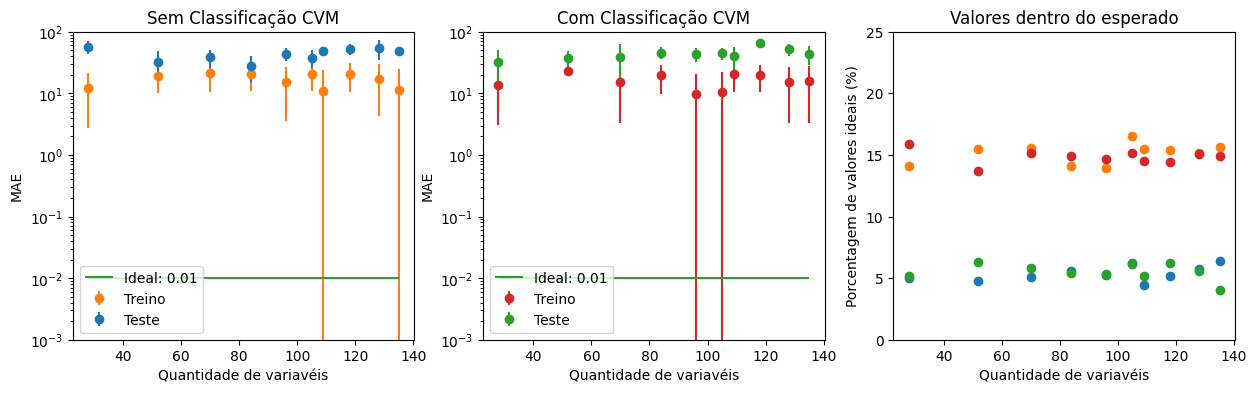

In [47]:
plot_erros(saida_dados_12)

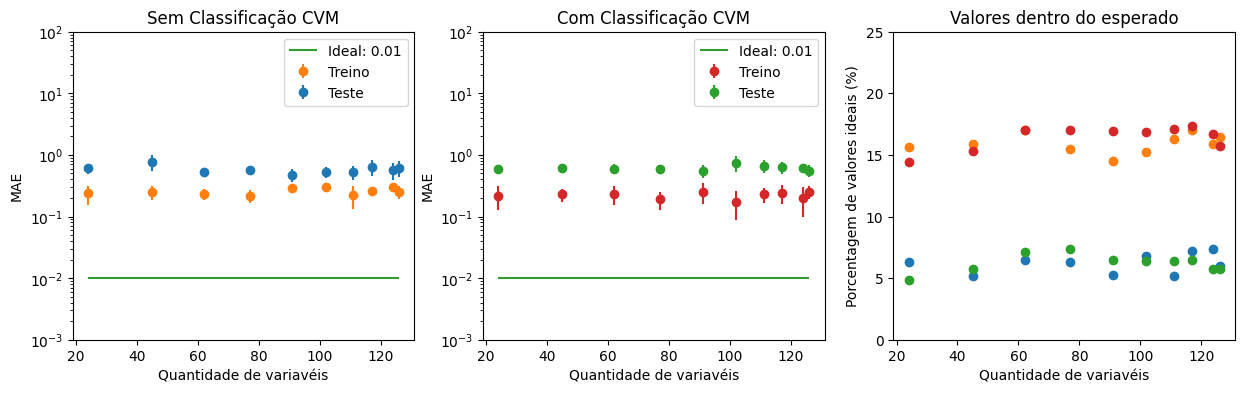

In [48]:
plot_erros(saida_dados_24)

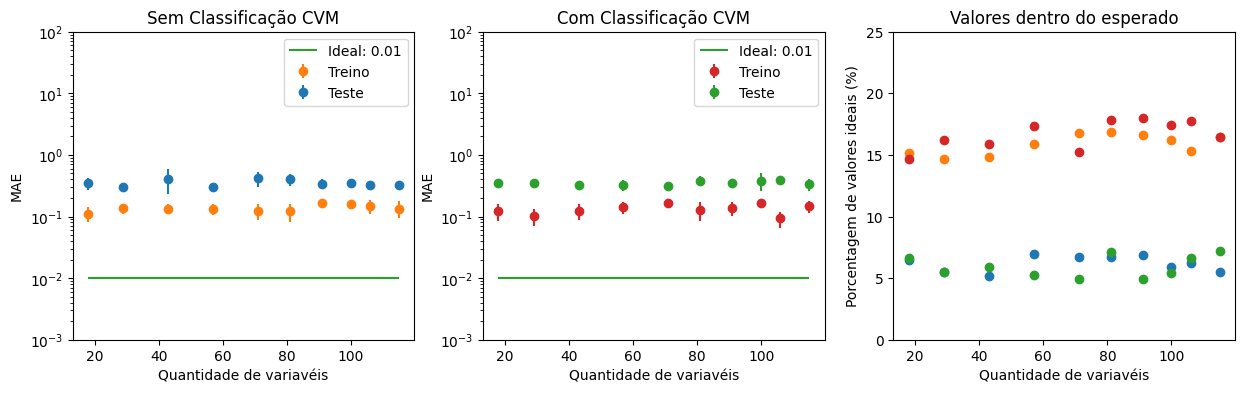

In [49]:
plot_erros(saida_dados_36)

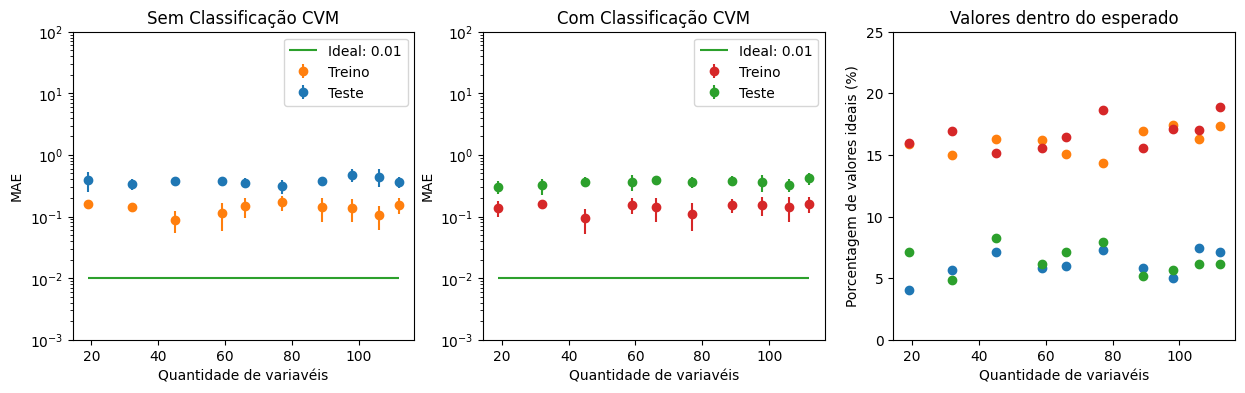

In [50]:
plot_erros(saida_dados_48)

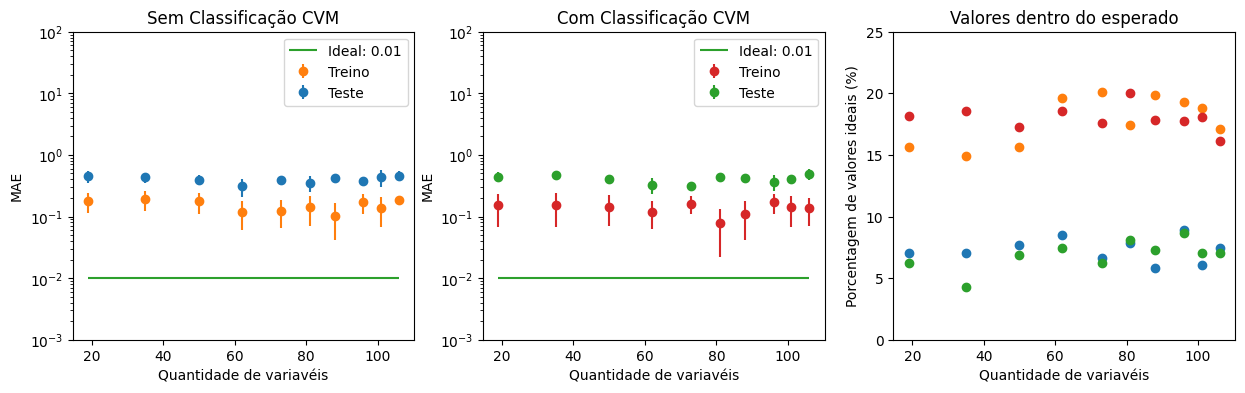

In [51]:
plot_erros(saida_dados_60)

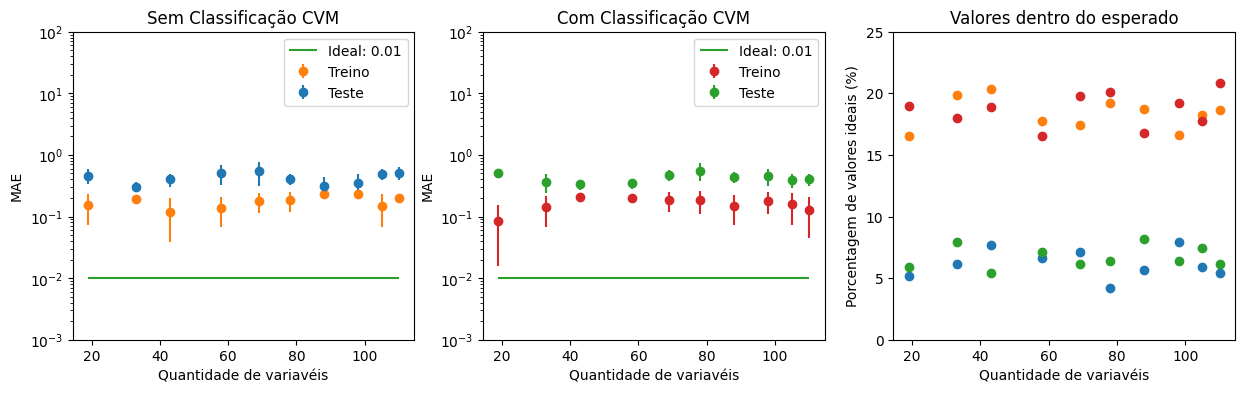

In [52]:
plot_erros(saida_dados_72)